In [ ]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

In [4]:
import json
with open('articles2019_n1.json', 'r', encoding='utf8') as f:
    papers = json.load(f)

In [5]:
keys = list(papers.keys())

In [24]:
len(papers)

1998

In [17]:
import numpy as np

In [25]:
from tqdm import tqdm
import numpy as np
embeddings = []

batches = np.arange(0, len(keys), 2)
for batch in tqdm(batches):
#     d =  {k:papers[k] for k in keys[batch:min(len(keys), batch+50)]}
    data = [papers[keys[i]]["ArticleTitle"] + tokenizer.sep_token + papers[keys[i]]["AbstractText"] for i in range(batch, min(batch+2, 1998))]
    inputs = tokenizer(data, padding=True, truncation=True, return_tensors="pt", max_length=512)
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings.append(result.last_hidden_state[:, 0, :].detach().numpy())

100%|██████████| 999/999 [40:55<00:00,  2.46s/it]


In [26]:
embeddings_= np.concatenate(embeddings)

In [27]:
embeddings_.shape

(1998, 768)

In [52]:
import pickle as pkl
with open('embedding.pkl','wb') as f:
    pkl.dump(embeddings_, f)

In [2]:
import pickle as pkl
with open('embedding.pkl','rb') as f:
    embeddings_= pkl.load(f)
embeddings_.shape

(1998, 768)

In [6]:
from sklearn import decomposition
import pandas as pd
pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings_),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["query"] = [paper["query"] for paper in papers.values()]

In [29]:
embeddings_pca['query'].unique()

array(['Alzheimer', 'Alzheimer&Cancer', 'Cancer'], dtype=object)

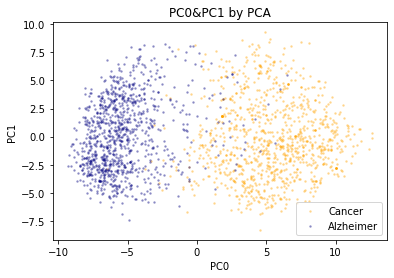

In [21]:
import matplotlib.pyplot as plt
plt.scatter(embeddings_pca[(embeddings_pca['query']=='Cancer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC0'], embeddings_pca[(embeddings_pca['query']=='Cancer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC1'], c='orange', alpha=.3, s=2.5, label = 'Cancer')
plt.scatter(embeddings_pca[(embeddings_pca['query']=='Alzheimer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC0'], embeddings_pca[(embeddings_pca['query']=='Alzheimer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC1'],c='navy', alpha=.3, s=2.5, label= 'Alzheimer')
plt.legend()
plt.title('PC0&PC1 by PCA')
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.show()

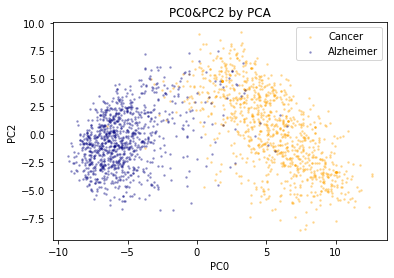

In [22]:
plt.scatter(embeddings_pca[(embeddings_pca['query']=='Cancer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC0'], embeddings_pca[(embeddings_pca['query']=='Cancer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC2'], c='orange', alpha=.3, s=2.5, label = 'Cancer')
plt.scatter(embeddings_pca[(embeddings_pca['query']=='Alzheimer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC0'], embeddings_pca[(embeddings_pca['query']=='Alzheimer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC2'],c='navy', alpha=.3, s=2.5, label= 'Alzheimer')
plt.legend()
plt.title('PC0&PC2 by PCA')
plt.xlabel('PC0')
plt.ylabel('PC2')
plt.show()

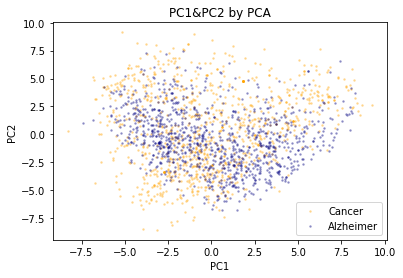

In [23]:
plt.scatter(embeddings_pca[(embeddings_pca['query']=='Cancer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC1'], embeddings_pca[(embeddings_pca['query']=='Cancer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC2'], c='orange', alpha=.3, s=2.5, label = 'Cancer')
plt.scatter(embeddings_pca[(embeddings_pca['query']=='Alzheimer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC1'], embeddings_pca[(embeddings_pca['query']=='Alzheimer')|(embeddings_pca['query']=='Alzheimer&Cancer')]['PC2'],c='navy', alpha=.3, s=2.5, label= 'Alzheimer')
plt.legend()
plt.title('PC1&PC2 by PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

categories = [paper["query"] for paper in papers.values()]
lda = LinearDiscriminantAnalysis(n_components=1)
embeddings_lda_1 = pd.DataFrame(
  lda.fit_transform(embeddings_, categories), columns=["lda0"]
)
lda = LinearDiscriminantAnalysis(n_components=2)
embeddings_lda_2 = pd.DataFrame(
  lda.fit_transform(embeddings_, categories), columns=["lda0","lda1"]
)
embeddings_lda_1["query"] = categories
embeddings_lda_2["query"] = categories

In [25]:
embeddings_lda_1

,lda0,query
0,-4.193758,Alzheimer
1,-5.243162,Alzheimer
2,-5.066474,Alzheimer
3,-3.609222,Alzheimer
4,-2.472734,Alzheimer
...,...,...
1993,4.387617,Cancer
1994,3.414600,Cancer
1995,3.462947,Cancer
1996,3.970810,Cancer


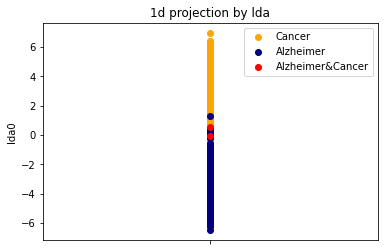

In [41]:
plt.scatter([0]*len(embeddings_lda_1[embeddings_lda_1['query']=='Cancer']['lda0']),embeddings_lda_1[embeddings_lda_1['query']=='Cancer']['lda0'], c = 'orange',label='Cancer')
plt.scatter([0]*len(embeddings_lda_1[embeddings_lda_1['query']=='Alzheimer']['lda0']),embeddings_lda_1[embeddings_lda_1['query']=='Alzheimer']['lda0'], c = 'navy',label='Alzheimer')
plt.scatter([0]*len(embeddings_lda_1[embeddings_lda_1['query']=='Alzheimer&Cancer']['lda0']),embeddings_lda_1[embeddings_lda_1['query']=='Alzheimer&Cancer']['lda0'], c = 'red',label='Alzheimer&Cancer')
plt.title('1d projection by lda')
plt.legend()
# plt.xticks([0, 1, 2], ['Cancer', 'Alzheimer', 'Alzheimer&Cancer'])
plt.xticks([0], [''])


# plt.xlabel('class')
plt.ylabel('lda0')
plt.show()

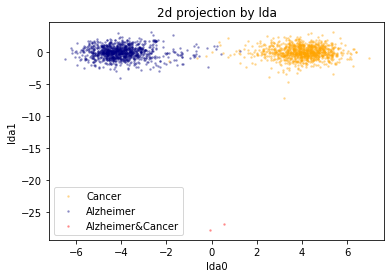

In [43]:
plt.scatter(embeddings_lda_2[embeddings_lda_2['query']=='Cancer']['lda0'], embeddings_lda_2[embeddings_lda_2['query']=='Cancer']['lda1'], c='orange', alpha=.3, s=2.5, label = 'Cancer')
plt.scatter(embeddings_lda_2[embeddings_lda_2['query']=='Alzheimer']['lda0'], embeddings_lda_2[embeddings_lda_2['query']=='Alzheimer']['lda1'],c='navy', alpha=.3, s=2.5, label= 'Alzheimer')
plt.scatter(embeddings_lda_2[embeddings_pca['query']=='Alzheimer&Cancer']['lda0'], embeddings_lda_2[embeddings_pca['query']=='Alzheimer&Cancer']['lda1'],c='red', alpha=.3, s=2.5, label= 'Alzheimer&Cancer')
plt.legend()
plt.title('2d projection by lda')
plt.xlabel('lda0')
plt.ylabel('lda1')
plt.show()